In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_colwidth', None) # Display full column content
pd.set_option('display.width', 1000) # Set larger display width

In [2]:
# Read data files
input_filepath = '/kaggle/input'
train_data = pd.read_csv(input_filepath + '/playground-series-s5e7/train.csv')
test_data = pd.read_csv(input_filepath + '/playground-series-s5e7/test.csv')

# Get numeric and categorical columns of training data
train_numeric_cols = train_data.select_dtypes(include='number')
train_categorical_cols = train_data.select_dtypes(include='object')
assert train_numeric_cols.shape[1] + train_categorical_cols.shape[1] == train_data.shape[1]

# Set target column
target_col='Personality'
# Drop id column from numeric columns
train_numeric_cols.drop('id', axis=1, inplace=True)
# Drop personality column from categorical columns
train_categorical_cols.drop(target_col, axis=1, inplace=True)

# Set an arbitrary value that can be used to specify the random_state later
random_state = 11

In [3]:
def print_basic_info(dataset_name, dataset):
    print('\n' + dataset_name + ' shape:', dataset.shape)
    print(dataset_name + ' missing values:')
    print(dataset.isnull().sum())

# Take a look at training dataset
print_basic_info('Training dataset', train_data)
# Take a look at test dataset
print_basic_info('Test dataset', test_data)


Training dataset shape: (18524, 9)
Training dataset missing values:
id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

Test dataset shape: (6175, 8)
Test dataset missing values:
id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


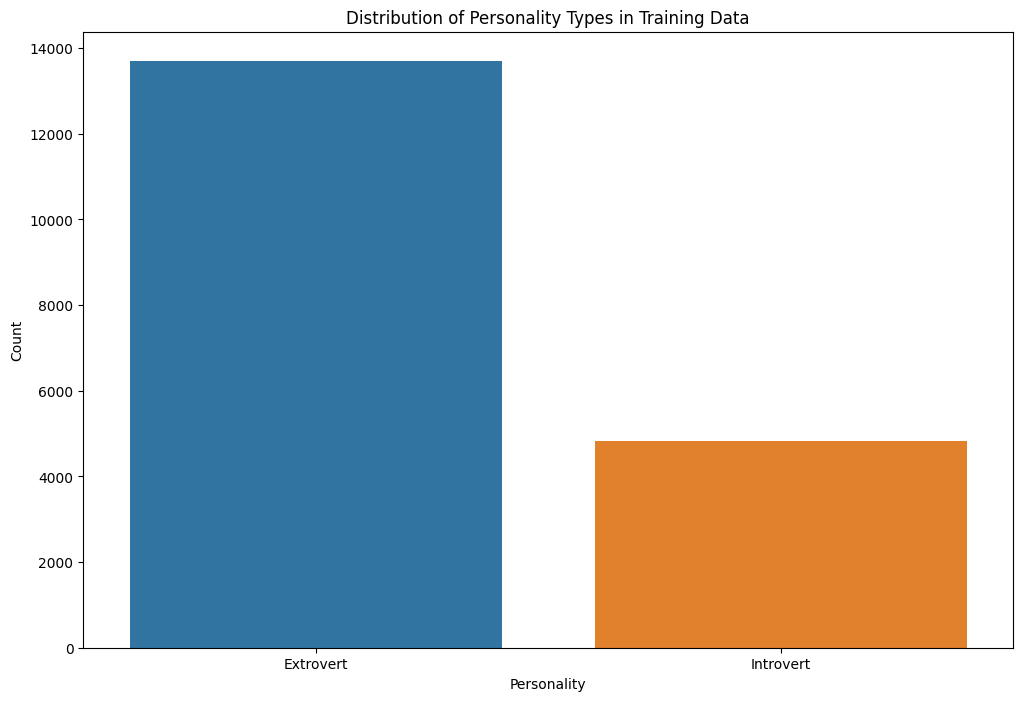

In [4]:
# See the distribution of personality types in the training data
plt.figure(figsize=(12, 8))
sns.countplot(x='Personality', data=train_data)
plt.title('Distribution of Personality Types in Training Data')
plt.xlabel('Personality')
plt.ylabel('Count')
plt.show()

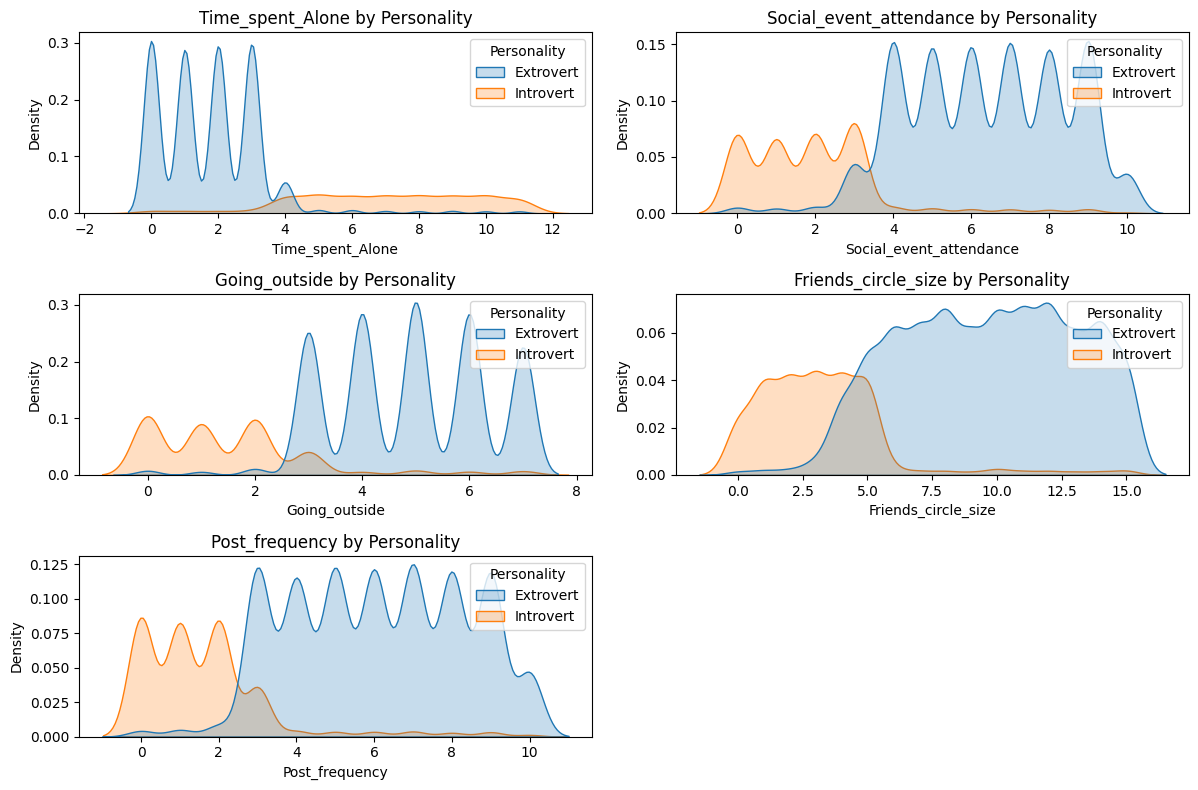

In [5]:
# KDE plots of numerical features with target variable as hue
plt.figure(figsize=(12, 8))
for i, col in enumerate(train_numeric_cols.columns, start=1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=train_data, x=col, hue='Personality', shade=True)
    plt.tight_layout()
    plt.title(f'{col} by Personality')

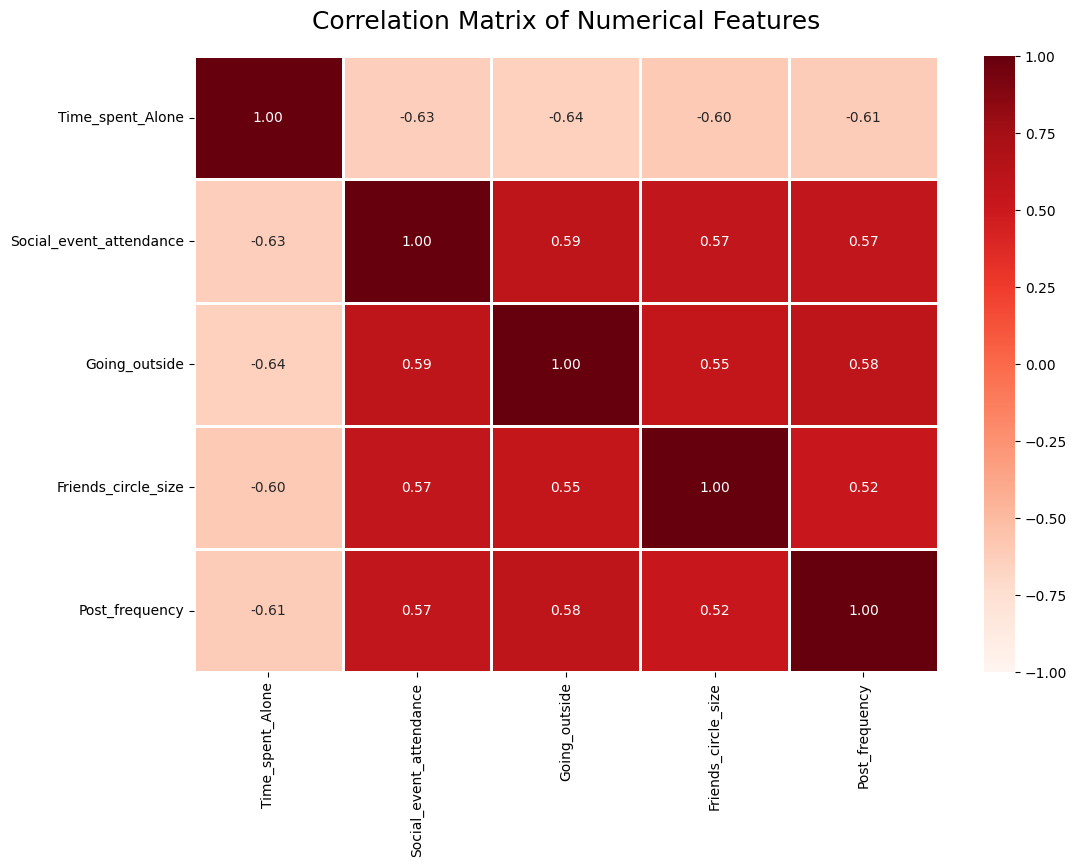

In [6]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_data[train_numeric_cols.columns].corr(),
    cmap='Reds',
    annot=True,
    linewidths=2,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Numerical Features', fontsize=18, pad=20)
plt.show()

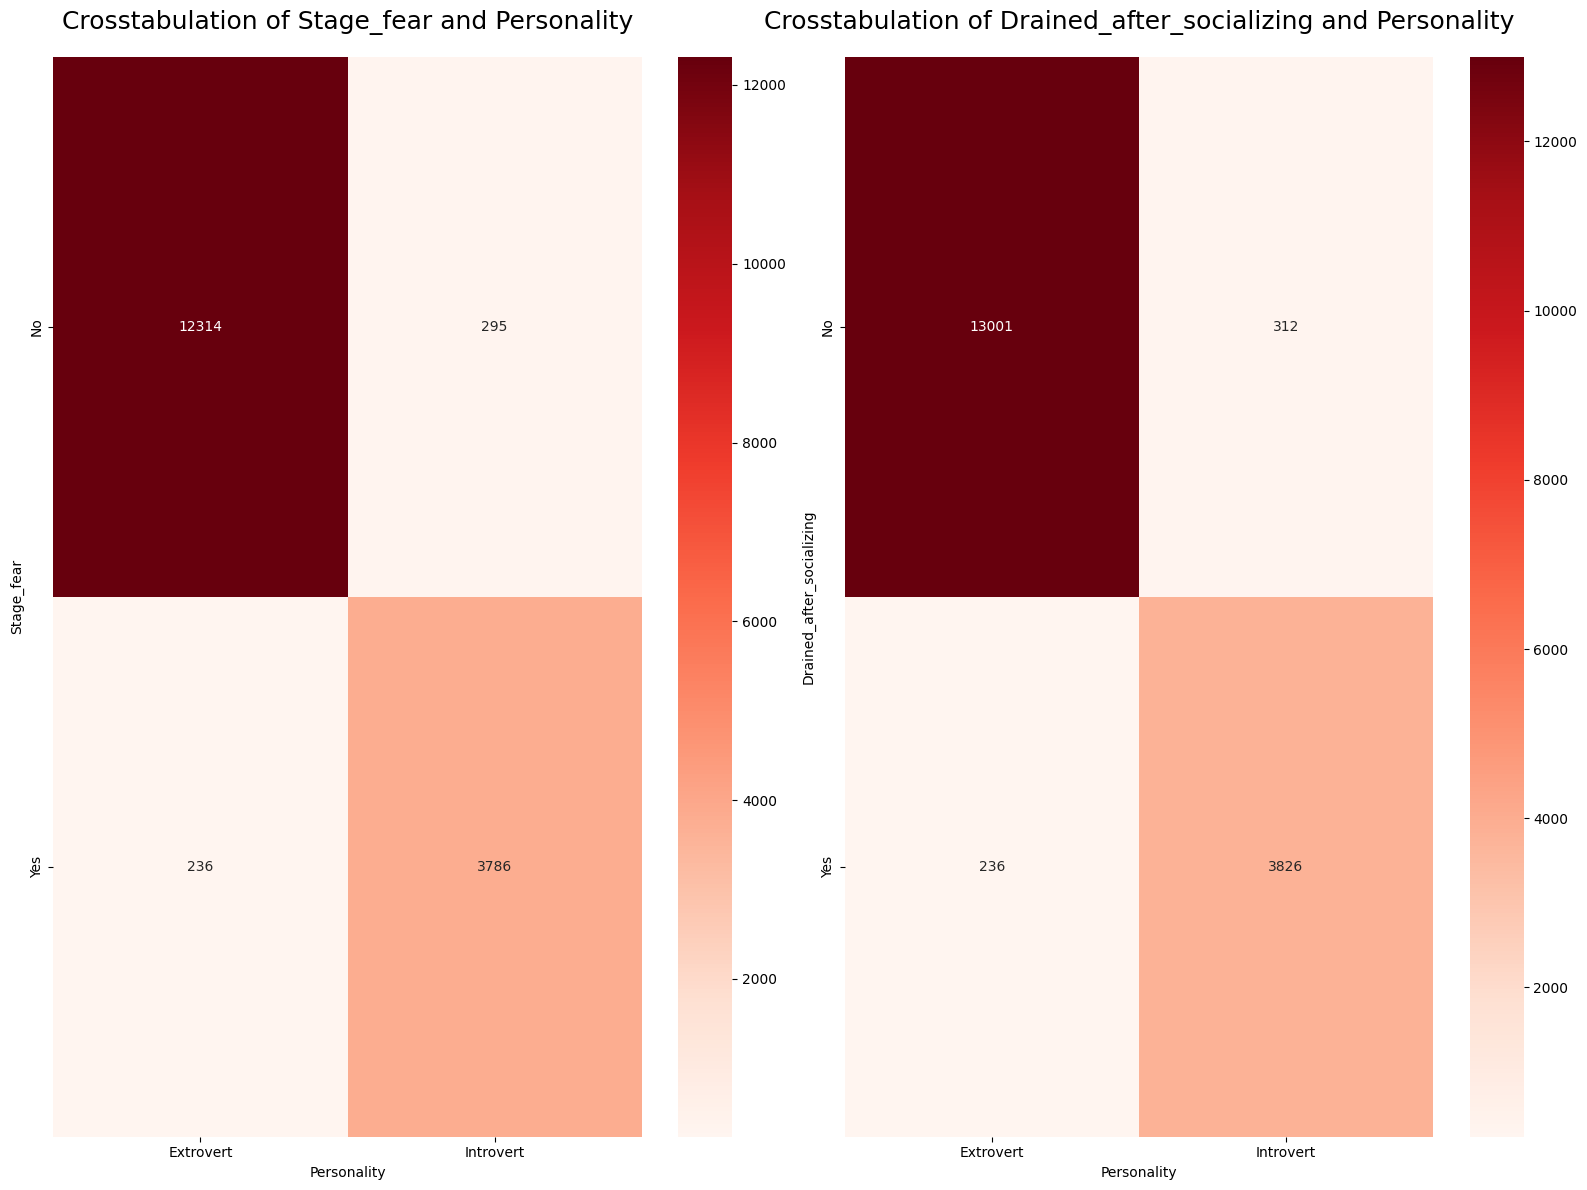

In [7]:
# Crosstabulation of categorical features with target variable
plt.figure(figsize=(16, 12))
for i, col in enumerate(train_categorical_cols.columns, start=1):
    plt.subplot(1, 2, i)
    crosstab = pd.crosstab(train_data[col], train_data['Personality'])
    sns.heatmap(crosstab, cmap='Reds', annot=True, fmt='d')
    plt.tight_layout()
    plt.title(f'Crosstabulation of {col} and Personality', fontsize=18, pad=20)

In [8]:
# Prepare dataframes that will be used for training and prediction
X_train = train_data.drop(['id', target_col], axis=1)
y_train = train_data[target_col]
X_test = test_data.drop(['id'], axis=1)

# Encode target variable
lbl_encoder = LabelEncoder()
y_train = pd.Series(lbl_encoder.fit_transform(y_train))
print(f"Label encoding complete with class labels: {lbl_encoder.classes_}\n")

# Handle missing values for numeric features: impute with median
numeric_imputer = SimpleImputer(strategy='median')
X_train[train_numeric_cols.columns] = numeric_imputer.fit_transform(X_train[train_numeric_cols.columns])
X_test[train_numeric_cols.columns] = numeric_imputer.fit_transform(X_test[train_numeric_cols.columns])

# Handle missing values for categorical features: impute with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[train_categorical_cols.columns] = categorical_imputer.fit_transform(X_train[train_categorical_cols.columns])
X_test[train_categorical_cols.columns] = categorical_imputer.fit_transform(X_test[train_categorical_cols.columns])

# Encode categorical features
X_train = pd.get_dummies(
    X_train,
    columns=train_categorical_cols.columns,
    drop_first=True,
    dtype=int
)
X_test = pd.get_dummies(
    X_test,
    columns=train_categorical_cols.columns,
    drop_first=True,
    dtype=int
)

# Feature generation
social_index_train = (X_train['Social_event_attendance'] + X_train['Friends_circle_size'] + X_train['Post_frequency']) / 3
social_index_test = (X_test['Social_event_attendance'] + X_test['Friends_circle_size'] + X_test['Post_frequency']) / 3
social_discomfort_index_train = (X_train['Stage_fear_Yes'] + X_train['Drained_after_socializing_Yes']) / 2
social_discomfort_index_test = (X_test['Stage_fear_Yes'] + X_test['Drained_after_socializing_Yes']) / 2
X_train['Social_comfort'] = social_index_train - (social_discomfort_index_train * social_index_train.median())
X_test['Social_comfort'] = social_index_test - (social_discomfort_index_test * social_index_test.median())
X_train['Outside_exposure'] = ((X_train['Going_outside'] + X_train['Social_event_attendance']) / 2) - X_train['Time_spent_Alone']
X_test['Outside_exposure'] = ((X_test['Going_outside'] + X_test['Social_event_attendance']) / 2) - X_test['Time_spent_Alone']

# Cap outliers
for col in train_numeric_cols:
    print(f'Capping outliers if necessary for column {col}:')
    first_quartile = train_data[col].quantile(0.25)
    third_quartile = train_data[col].quantile(0.75)
    interquartile_range = third_quartile - first_quartile
    lower_threshold = first_quartile - 1.5 * interquartile_range
    upper_threshold = third_quartile + 1.5 * interquartile_range
    num_values_trimmed_for_train_data = sum(1 for x in train_data[col] if (x < lower_threshold or x > upper_threshold))
    num_values_trimmed_for_test_data = sum(1 for x in test_data[col] if (x < lower_threshold or x > upper_threshold))
    train_data[col] = train_data[col].clip(lower=lower_threshold, upper=upper_threshold)
    test_data[col] = test_data[col].clip(lower=lower_threshold, upper=upper_threshold)
    print(f'{num_values_trimmed_for_train_data} values will be trimmed for train_data')
    print(f'{num_values_trimmed_for_test_data} values will be trimmed for test_data')

# Prepare dataframes of scaled features
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

Label encoding complete with class labels: ['Extrovert' 'Introvert']

Capping outliers if necessary for column Time_spent_Alone:
1653 values will be trimmed for train_data
529 values will be trimmed for test_data
Capping outliers if necessary for column Social_event_attendance:
0 values will be trimmed for train_data
0 values will be trimmed for test_data
Capping outliers if necessary for column Going_outside:
0 values will be trimmed for train_data
0 values will be trimmed for test_data
Capping outliers if necessary for column Friends_circle_size:
0 values will be trimmed for train_data
0 values will be trimmed for test_data
Capping outliers if necessary for column Post_frequency:
0 values will be trimmed for train_data
0 values will be trimmed for test_data


In [9]:
# Define the estimators that will be passed to GridSearchCV for hyperparameter tuning
# Note that the values for the parameter grid have already been adjusted after several iterations
estimator_key = 'estimator'
param_grid_key = 'param_grid'
use_scaled_features_key = 'use_scaled_features'
grid_search_cv_estimators = {
    'logistic_reg': {
        estimator_key: LogisticRegression(random_state=random_state),
        param_grid_key: {
            'C': [0.0001, 0.001, 0.1],
            'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky'],
            'max_iter': list(range(25, 200, 25))
        },
        use_scaled_features_key: True
    },
    'random_forest': {
        estimator_key: RandomForestClassifier(random_state=random_state),
        param_grid_key: {
            'n_estimators': list(range(150, 350, 25)),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': list(range(1, 3, 1)),
        },
        use_scaled_features_key: False
    },
    'gradient_boost': {
        estimator_key: GradientBoostingClassifier(random_state=random_state),
        param_grid_key: {
            'learning_rate': [0.01, 0.1],
            'n_estimators': list(range(150, 300, 25)),
            'max_depth': list(range(1, 3, 1))
        },
        use_scaled_features_key: False
    },
    'xgb': {
        estimator_key: XGBClassifier(random_state=random_state, eval_metric=['logloss']),
        param_grid_key: {
            'learning_rate': [0.01, 0.1],
            'n_estimators': list(range(300, 450, 25)),
            'max_depth': list(range(2, 4, 1))
        },
        use_scaled_features_key: False
    },
    'k-neighbors': {
        estimator_key: KNeighborsClassifier(),
        param_grid_key: {
            'n_neighbors': list(range(6, 8, 1)),
            'weights': ['uniform', 'distance']
        },
        use_scaled_features_key: True
    },
    'support_vector': {
        estimator_key: SVC(probability=True, random_state=random_state),
        param_grid_key: {
            'C': [0.01, 0.1, 1],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        },
        use_scaled_features_key: True
    }
}

In [10]:
# Perform hyperparameter tuning using GridSearchCV
results = []
for estimator_name, estimator in grid_search_cv_estimators.items():
    print('Executing GridSearchCV for', estimator_name)
    gscv = GridSearchCV(
        estimator[estimator_key],
        estimator[param_grid_key],
        n_jobs=-1,
        scoring='f1_weighted',
        verbose=1
    )
    X_to_train_on = X_train_scaled if estimator[use_scaled_features_key] else X_train
    gscv.fit(X_to_train_on, y_train)
    results.append({
        'estimator': estimator_name,
        'best_score': gscv.best_score_,
        'best_params': gscv.best_params_
    })
results = pd.DataFrame(results).sort_values(by='best_score', ascending=False)

print('Results:')
print(results)

Executing GridSearchCV for logistic_reg
Fitting 5 folds for each of 84 candidates, totalling 420 fits
Executing GridSearchCV for random_forest
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Executing GridSearchCV for gradient_boost
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Executing GridSearchCV for xgb
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Executing GridSearchCV for k-neighbors
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Executing GridSearchCV for support_vector
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Results:
        estimator  best_score                                                   best_params
3             xgb    0.969019  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}
2  gradient_boost    0.969017  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
1   random_forest    0.968915    {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 150}
0    logistic_reg  

In [11]:
# Pick XGBoost which got the best score, and use the parameters returned
xgb_classifier = XGBClassifier(
    n_estimators=300,
    max_depth=2,
    learning_rate=0.01,
    n_jobs=-1,
    random_state=random_state
)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=11, ...)

In [12]:
# Get predictions of target variable
y_preds = xgb_classifier.predict(X_test)
# Convert predictions from '0's and '1's back to 'Extrovert' and 'Introvert'
preds = ['Introvert' if is_introvert else 'Extrovert' for is_introvert in y_preds]
# Prepare submission
submission = pd.DataFrame({'id': test_data['id'], 'Personality': preds})
submission.to_csv('submission.csv', index=False)